# Azure Cognitive Services で AI プログラミング

## 0. 準備 - Cognitive Services 接続情報を確認

このハンズオンでは Azure Cognitive Services で提供されている **事前構築済みの AI** を利用して AI 開発を体験します。

最初に Cognitive Services の接続情報が正しく設定されているかを確認します。

> 集合形式のハンズオンではあらかじめ接続情報が設定されているかもしれません。  
> その場合は、以下のセルを実行すると、エンドポイントとキーの値が表示されます。
>
> [**Cognitive リソースの作成**](./a01_createcog.ipynb) および [**ハンズオンの環境構築**](./0_setup.ipynb) を実施する必要があります。

In [1]:
from dotenv import load_dotenv
import os

In [2]:
# Cognitive Services 利用のために Endpoint と Key とを読み込みます
load_dotenv()
cog_endpoint = os.getenv('COG_SERVICE_ENDPOINT')
cog_key = os.getenv('COG_SERVICE_KEY')

In [3]:
print("Endpoint: " + cog_endpoint)
print("Key: " + cog_key)

Endpoint: https://occogdev.cognitiveservices.azure.com/
Key: e9311b33dbd0441394ccc594dd3a916c


---

## 1. 画像分析

In [27]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [28]:
# 画像のパスを決定
image_path = os.path.join('data', 'vision', 'image1.jpg')

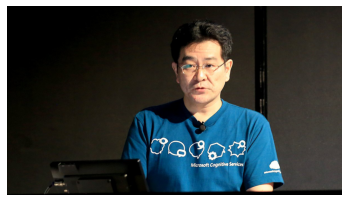

In [29]:
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

In [30]:
# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))

# Get a description from the computer vision service
image_stream = open(image_path, "rb")
#description = computervision_client.describe_image_in_stream(image_stream)
description = computervision_client.describe_image_in_stream(image_stream, language="ja")

In [31]:
print(description)

{'additional_properties': {}, 'tags': ['人', '男', '屋内', 'シャツ', '衣類', '探す', 'テーブル', 'フロント', 'ノートパソコン', '座る', 'ブルー', '若い', '立つ', '持つ', 'コンピュータ', '微笑み', 'メガネ', 'リモコン', '紫', '食品', '部屋', 'ビデオ'], 'captions': [<azure.cognitiveservices.vision.computervision.models._models_py3.ImageCaption object at 0x000001E311E88310>], 'request_id': '1ebb9c35-d7d5-4dbc-b06e-5df272a68c31', 'metadata': <azure.cognitiveservices.vision.computervision.models._models_py3.ImageMetadata object at 0x000001E311F67430>, 'model_version': '2021-05-01'}


In [32]:
for tag in description.tags:
    print(tag)

人
男
屋内
シャツ
衣類
探す
テーブル
フロント
ノートパソコン
座る
ブルー
若い
立つ
持つ
コンピュータ
微笑み
メガネ
リモコン
紫
食品
部屋
ビデオ


In [36]:
print(description.captions[0])

{'additional_properties': {}, 'text': '青いシャツを着た男性', 'confidence': 0.8090890452320457}


In [38]:
for caption in description.captions:
    print(f'{caption.text} ({(caption.confidence * 100):.1f}%)')

青いシャツを着た男性 (80.9%)


In [16]:
image_stream = open(image_path, "rb")

features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']
#analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features, language="ja")

In [17]:
print(analysis)

{'additional_properties': {}, 'categories': None, 'adult': <azure.cognitiveservices.vision.computervision.models._models_py3.AdultInfo object at 0x000001E311F3C550>, 'color': None, 'image_type': None, 'tags': [<azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311F89BE0>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311F89F10>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311F89A90>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311F89A30>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311F89D60>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311FAC460>, <azure.cognitiveservices.vision.computervision.models._models_py3.ImageTag object at 0x000001E311FACF70>, <azure.cognitiveservices.vision.computervision.m

In [20]:
for tag in analysis.tags:
    print(f'{tag.name} ({(tag.confidence * 100):.1f}%)')

人の顔(99.6%)
人(99.2%)
衣類(98.8%)
メガネ(96.9%)
ノート pc(92.3%)
コンピューター(87.0%)
男(86.6%)
屋内(84.8%)
壁(75.2%)


In [40]:
for object in analysis.objects:
    print(object)

{'additional_properties': {}, 'rectangle': <azure.cognitiveservices.vision.computervision.models._models_py3.BoundingRect object at 0x000001E311FAC1F0>, 'object_property': 'person', 'confidence': 0.959, 'parent': None}


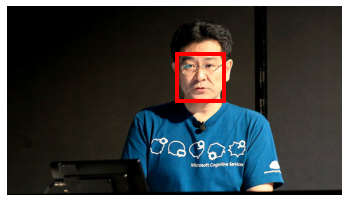

In [74]:
import matplotlib.patches as patches

plt.axis('off')
plt.imshow(img)

ax = plt.gca()

for face in analysis.faces:
    bound = face.face_rectangle
  
    rect = patches.Rectangle((bound.left, bound.top),
                     bound.width,
                     bound.height,
                     linewidth=4,
                     edgecolor='red',
                     fill = False)

    ax.add_patch(rect)

plt.show()

In [75]:
print(f'{len(analysis.faces)}人の人が写っています')

for face in analysis.faces:
    print(f'{"男性" if face.gender == "Male" else "女性"} {face.age}歳')

1人の人が写っています
男性 56歳
